In [1]:
# standing data tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

# sklearn
from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
# persistence
from sklearn.externals import joblib

#plt.style.use('seaborn-white')
%matplotlib inline
#%matplotlib notebook

## Analysis Setup

In [2]:
hasLabel=True
Tag='Truth'
outdir='fig/Benchmark/'+Tag
import os
os.system('mkdir -p '+outdir)
#Load the dataset
data=pd.read_csv('../data/round2/batch2_all_viable_merged_v2.csv')
# aliases for slicer info
data.rename(columns={'Runtime (s)':'t','Fill Vol (mm^3)':'Vfil','Support Vol (mm^3)':'Vsup','Layer Height':'dh'},inplace=True)
# aliases for basic mesh info
data.rename(columns={'Volume':'Vmes','Surface Area':"Sa",'BB Vol':'Vbb','BC vol':'Vbc','BS vol':'Vbs','CVHull Vol':'Vch','Euler Number':'Euler'},inplace=True)
# aliases for engineered features
data.rename(columns={'DownArea':'Sdown','Adj DownArea':'Vdown','Ang DownArea':'Sangover','Magic Number':'Vangover'},inplace=True)

# convert unit
print 'before conversion:', data.t[1]
volvars=['Vfil','Vsup','Vmes','Vbb','Vbc','Vbs','Vch','Vdown','Vangover']
areavars=['Sa','Sdown','Sangover']
lenvars=['X','Y','Z']
factor=0.1
for i in range(len(lenvars)):
    data[lenvars[i]]=data[lenvars[i]].apply(lambda x: factor*x)
for i in range(len(areavars)):
    data[areavars[i]]=data[areavars[i]].apply(lambda x: np.power(factor,2)*x)
for i in range(len(volvars)):
    data[volvars[i]]=data[volvars[i]].apply(lambda x: np.power(factor,3)*x)
data['t']=data['t'].apply(lambda x:np.divide(x,60.))
print 'after conversion:', data.t[1]

# add branches
data['rSaVmes']=data['Sa'].div(data['Vmes'])
data['rVbbVmes']=data['Vbb'].div(data['Vmes'])
data['rVbcVmes']=data['Vbc'].div(data['Vmes'])
data['rVbsVmes']=data['Vbs'].div(data['Vmes'])
data['rVchVmes']=data['Vch'].div(data['Vmes'])
data['rXVmes']=data['X'].div(data['Vmes'])
data['rZVmes']=data['Z'].div(data['Vmes'])                       
data.info()

before conversion: 28401
after conversion: 473.35
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3050 entries, 0 to 3049
Data columns (total 50 columns):
Unnamed: 0       3050 non-null int64
File             3050 non-null object
Output           3050 non-null object
Cura Setting     3050 non-null object
dh               3050 non-null float64
t                3050 non-null float64
Vfil             3050 non-null float64
Vsup             3050 non-null float64
Load Time        3050 non-null float64
File Size        3050 non-null int64
Time             3050 non-null float64
Watertight       3050 non-null bool
Time.1           3050 non-null float64
NumBodies        3050 non-null float64
Time.2           3050 non-null float64
minZ             3050 non-null float64
Time.3           3050 non-null float64
X                3050 non-null float64
Y                3050 non-null float64
Z                3050 non-null float64
Time.4           3050 non-null float64
Vmes             3050 non-null flo

In [3]:
data[['t','Vfil','Vsup','Vmes','Vbb','Vbc','Vbs','Vch','Vdown','Vangover']].describe()
#data[['File','t','Vfil','Vsup','Vmes','Vbb','Sa','Z']][data.rZVmes>10000]

,t,Vfil,Vsup,Vmes,Vbb,Vbc,Vbs,Vch,Vdown,Vangover
count,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3.050000e+03,3.050000e+03
mean,1076.640158,46.626955,8.099674,49.015732,228.847761,287.751807,788.354284,136.234325,5.557536e+01,4.242007e+01
std,2384.449660,98.666504,61.611520,104.503552,433.498222,532.720520,1111.121358,262.616491,2.375592e+02,2.218261e+02
min,0.000000,0.000000,0.000000,0.000001,16.403378,7.142770,14.140262,0.794706,-1.914563e-15,-1.914563e-15
25%,233.320833,9.629750,0.041000,9.923701,36.156702,46.658778,137.459454,23.573047,9.906574e-02,2.378416e-03
50%,455.300000,19.708500,0.228000,20.116887,77.542877,101.163270,348.986901,49.707732,4.583274e+00,2.403323e+00
75%,1020.391667,44.955750,2.009000,47.164483,213.292095,268.497313,979.194308,125.239912,2.770200e+01,1.827287e+01
max,48794.466667,1803.526000,1832.400000,1799.681097,5831.148835,7634.070925,13505.789852,4860.000165,8.168521e+03,8.158626e+03


In [4]:
data[['Sa','Sdown','Sangover','X','Y','Z','rSaVmes','rVbbVmes','rVbcVmes','rVbsVmes','rVchVmes','rZVmes']].describe()

,Sa,Sdown,Sangover,X,Y,Z,rSaVmes,rVbbVmes,rVbcVmes,rVbsVmes,rVchVmes,rZVmes
count,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3.050000e+03,3.050000e+03,3.050000e+03,3.050000e+03,3.050000e+03,3.050000e+03
mean,173.223110,93.795269,90.132665,6.925520,6.375370,4.367921,3.599837e+04,3.015800e+04,4.775035e+04,9.712844e+04,2.126569e+04,1.220289e+03
std,187.899737,1493.202978,1493.201059,3.717273,3.727602,3.529269,1.987676e+06,1.665160e+06,2.636610e+06,5.362154e+06,1.174232e+06,6.737746e+04
min,5.391088,0.000000,0.000000,0.600000,0.100000,0.100100,4.874053e-01,6.976446e-01,9.768409e-01,1.006633e+00,6.904732e-01,3.315239e-03
25%,62.954844,9.765207,7.902046,4.055820,3.638328,1.633471,3.314054e+00,2.444349e+00,2.926450e+00,7.186111e+00,1.495710e+00,6.298386e-02
50%,108.163842,20.202066,17.823136,6.160040,5.523972,3.200022,5.222963e+00,3.806680e+00,5.002777e+00,1.551678e+01,2.391943e+00,1.364529e-01
75%,215.813908,44.162376,39.346217,9.200000,8.264022,6.100000,8.846123e+00,6.967729e+00,9.349684e+00,3.527316e+01,4.183959e+00,2.989375e-01
max,2722.291588,56205.142738,56201.062599,18.660941,20.362334,18.711166,1.097730e+08,9.196148e+07,1.456116e+08,2.961347e+08,6.484908e+07,3.721042e+06


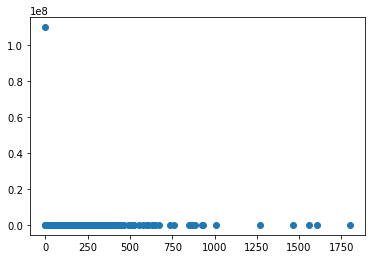

In [5]:
plt.scatter(data['Vmes'],data['rSaVmes'])

In [6]:
#filter dataset
Vmin=1.
Vmax=100000.
anafilter=(data['Vmes']>Vmin)&(data['Vmes']<Vmax)&(data['Watertight']==True)
sd=data[anafilter]

# cut numbers
ndata=len(data)
nselected=len(sd)
ntrain=np.int(nselected*0.8)
print 'total input:', ndata, 'total selected:', nselected, 'selection efficiency:', np.divide(nselected,np.float(ndata)), 'ntrain:', ntrain
# test first on the training set
sd=sd.head(ntrain)

total input: 3050 total selected: 3038 selection efficiency: 0.99606557377 ntrain: 2430


In [7]:
sd[['t','Vfil','Vsup','Vmes','Vbb','Vbc','Vbs','Vch','Vdown','Vangover']].describe()

,t,Vfil,Vsup,Vmes,Vbb,Vbc,Vbs,Vch,Vdown,Vangover
count,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2.430000e+03,2.430000e+03
mean,1092.812394,47.329752,8.223854,49.932585,233.787572,295.561753,805.969142,139.320807,5.736587e+01,4.427162e+01
std,2448.556535,99.778654,64.083805,106.794872,449.163254,554.493752,1148.292374,272.966215,2.529293e+02,2.401285e+02
min,0.000000,0.000000,0.000000,1.089815,16.487266,7.142770,14.140262,4.044090,-1.914563e-15,-1.914563e-15
25%,235.016667,9.796500,0.039000,10.063215,37.544343,47.958030,138.605558,24.475649,9.013323e-02,3.812013e-04
50%,461.066667,20.035000,0.210000,20.392044,78.875865,102.920133,359.307458,50.735995,4.634610e+00,2.319411e+00
75%,1010.529167,44.918750,1.979250,47.020399,214.351691,269.573343,978.600429,124.884282,2.770200e+01,1.825353e+01
max,48794.466667,1803.526000,1832.400000,1799.681097,5831.148835,7634.070925,13505.789852,4860.000165,8.168521e+03,8.158626e+03


In [8]:
sd[['Sa','Sdown','Sangover','X','Y','Z','rSaVmes','rVbbVmes','rVbcVmes','rVbsVmes','rVchVmes','rZVmes']].describe()

,Sa,Sdown,Sangover,X,Y,Z,rSaVmes,rVbbVmes,rVbcVmes,rVbsVmes,rVchVmes,rZVmes
count,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000
mean,175.877880,106.613112,102.961352,6.967896,6.413926,4.386692,6.948995,6.473169,8.437786,31.800367,3.639596,0.250258
std,193.575532,1667.140720,1667.156548,3.711480,3.741726,3.558933,5.824467,9.795008,13.238270,56.626900,4.325556,0.367760
min,16.615407,0.000000,0.000000,0.600000,0.200000,0.100100,0.487538,0.697645,1.005479,1.006633,0.697636,0.003315
25%,64.397092,9.997344,8.022720,4.151452,3.723236,1.600000,3.305666,2.455764,2.928798,7.184306,1.494111,0.062836
50%,109.705814,20.422316,18.063593,6.218285,5.560001,3.200000,5.219907,3.787833,4.974786,15.420816,2.349323,0.134819
75%,216.245298,45.002327,39.764666,9.200150,8.293223,6.180855,8.683869,6.967729,9.251878,35.057206,4.201834,0.293548
max,2722.291588,56205.142738,56201.062599,18.660086,20.362334,18.711166,81.037537,269.382467,247.086004,914.765216,90.738198,6.493395


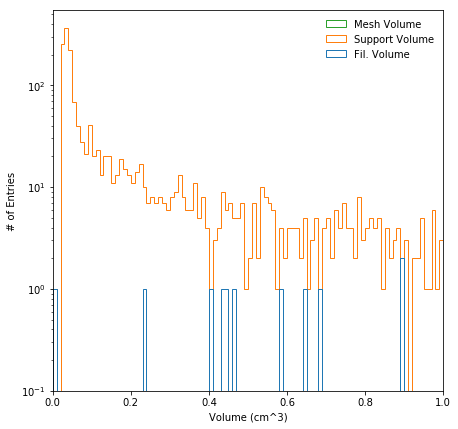

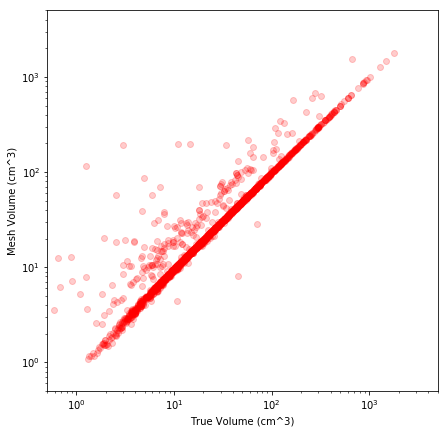

In [43]:
if hasLabel:
    fig0, axes0 = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
    axes0.hist([sd['Vfil'],sd['Vsup'],sd['Vmes']], 100,(0,1), histtype='step',label=['Fil. Volume','Support Volume','Mesh Volume'],log=True)
    axes0.legend(loc='best',framealpha=0)
    plt.xlim(0,1)
#    plt.xscale('log')
    plt.xlabel('Volume (cm^3)')
    plt.ylabel('# of Entries')
    fig0.savefig(outdir+'/'+'Volumes_Basic_Distr.png')
    
    fig0, axes0 = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
    axes0.scatter(sd['Vfil'],sd['Vmes'], color='red',marker='o',alpha=0.2)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.5,5000)
    plt.ylim(0.5,5000)
    plt.xlabel('True Volume (cm^3)')
    plt.ylabel('Mesh Volume (cm^3)')
    fig0.savefig(outdir+'/'+'Vfil_vs_Vmes.png')

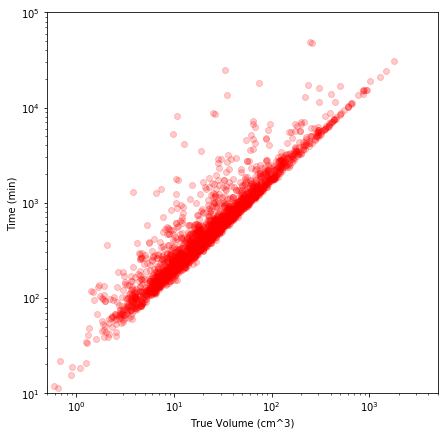

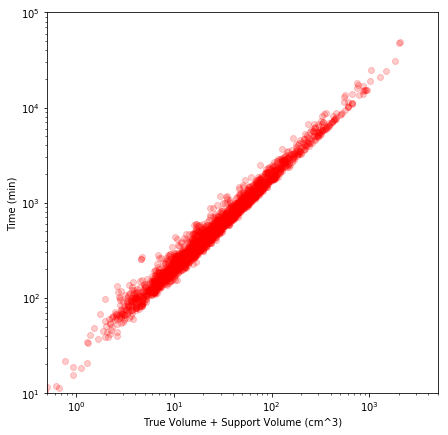

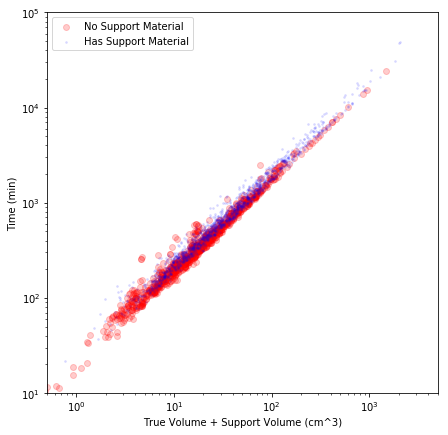

In [10]:
if hasLabel:
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
    axes.scatter(sd['Vfil'],sd['t'], color='red',marker='o',alpha=0.2)
    plt.xlabel('True Volume (cm^3)')
    plt.ylabel('Time (min)')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.5,5000)
    plt.ylim(ymin=10,ymax=100000)    
    fig.savefig(outdir+'/'+'Vfil_vs_t.png')
    
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
    axes.scatter(sd['Vfil']+sd['Vsup'],sd['t'], color='red',marker='o',alpha=0.2)
    plt.xlabel('True Volume + Support Volume (cm^3)')
    plt.ylabel('Time (min)')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.5,5000)
    plt.ylim(ymin=10,ymax=100000)    
    fig.savefig(outdir+'/'+'VfilAndVsup_vs_t.png')

    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
#    truthcut=(sd.Vsup<0.06)&(sd.Vmes/sd.Vfil<1.1) # tight cut
    truthcut=(sd.Vsup<0.06)
    axes.scatter(sd.Vfil[truthcut]+sd.Vsup[truthcut],sd.t[truthcut], color='red',marker='o',alpha=0.2,label='No Support Material')
    truthcut=(sd.Vsup>0.06)
    axes.scatter(sd.Vfil[truthcut]+sd.Vsup[truthcut],sd.t[truthcut], color='blue',marker='o',alpha=0.1,label='Has Support Material',s=3)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.5,5000)
    plt.ylim(ymin=10,ymax=100000)    
    plt.xlabel('True Volume + Support Volume (cm^3)')
    plt.ylabel('Time (min)')
    plt.legend(loc='best')
    fig.savefig(outdir+'/'+'VfilAndVsup_vs_t_truthcut_sup0.png')

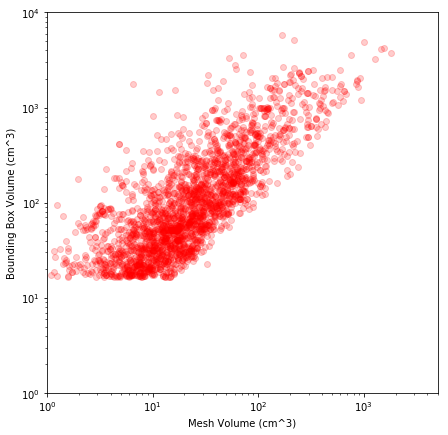

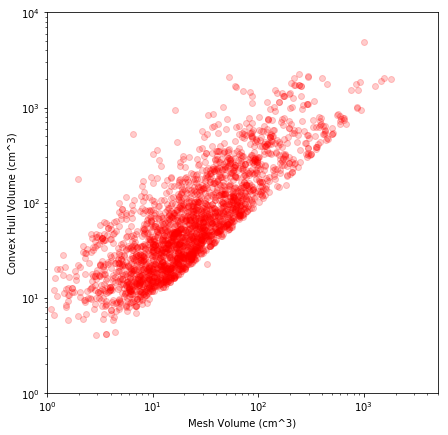

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
axes.scatter(sd['Vmes'],sd['Vbb'], color='red',marker='o',alpha=0.2)
plt.xlabel('Mesh Volume (cm^3)')
plt.ylabel('Bounding Box Volume (cm^3)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1,5000)
plt.ylim(1,10000)
fig.savefig(outdir+'/'+'Vmes_vs_Vbb.png')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
axes.scatter(sd['Vmes'],sd['Vch'], color='red',marker='o',alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1,5000)
plt.ylim(1,10000)
plt.xlabel('Mesh Volume (cm^3)')
plt.ylabel('Convex Hull Volume (cm^3)')
fig.savefig(outdir+'/'+'Vmes_vs_Vch.png')

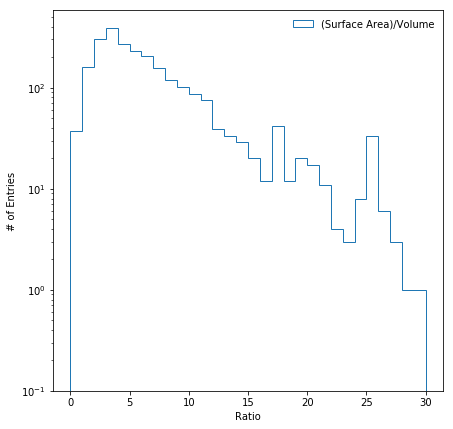

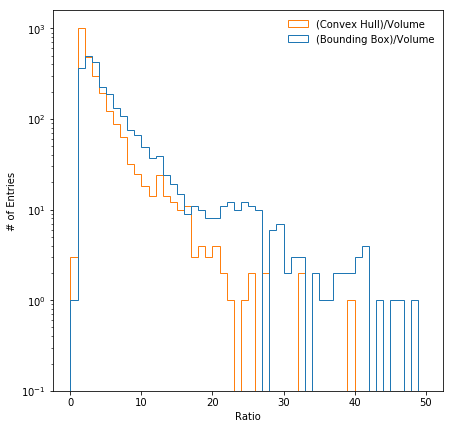

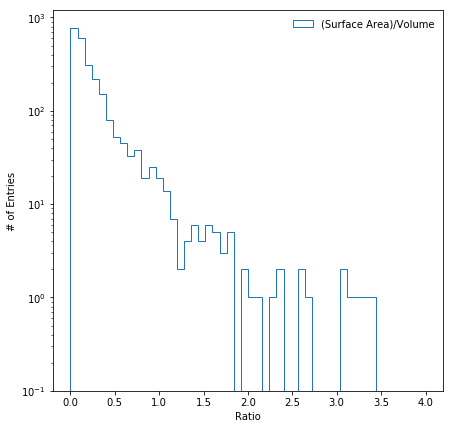

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
axes.hist(sd['rSaVmes'], 30,(0,30), histtype='step',label='(Surface Area)/Volume',log=True)
axes.legend(loc='best',framealpha=0)
plt.xlabel('Ratio')
plt.ylabel('# of Entries')
fig.savefig(outdir+'/'+'Ratio_Sa_to_Vmes.png')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
axes.hist([sd['rVbbVmes'],sd['rVchVmes']], 50,(0,50), histtype='step',label=['(Bounding Box)/Volume','(Convex Hull)/Volume'],log=True)
axes.legend(loc='best',framealpha=0)
#plt.xlim(0,50)
plt.xlabel('Ratio')
plt.ylabel('# of Entries')
fig.savefig(outdir+'/'+'Ratio_BB_CH_to_Vmes.png')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
axes.hist(sd['rZVmes'], 50,(0,4), histtype='step',label='(Surface Area)/Volume',log=True)
axes.legend(loc='best',framealpha=0)
plt.xlabel('Ratio')
plt.ylabel('# of Entries')
fig.savefig(outdir+'/'+'Ratio_Sa_to_Vmes.png')

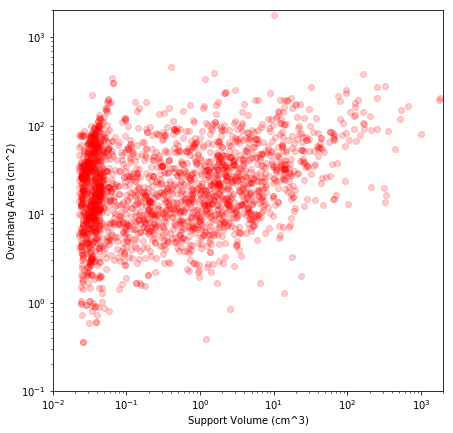

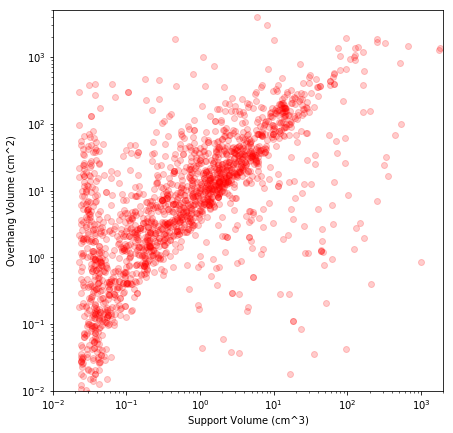

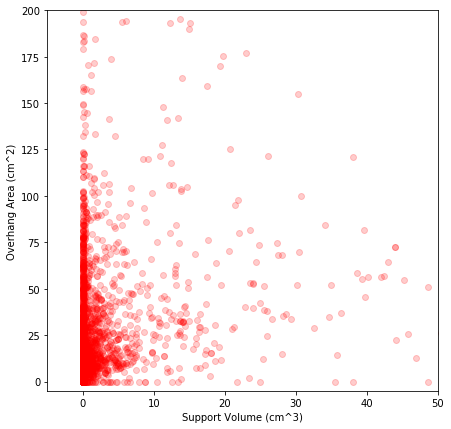

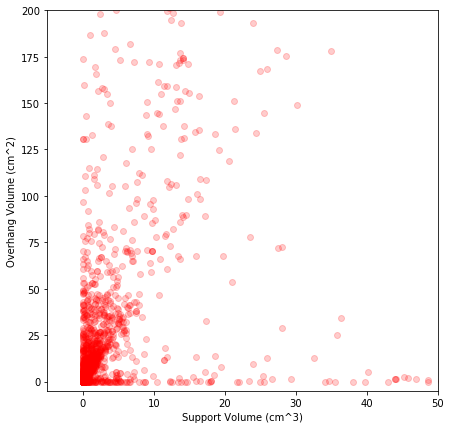

In [13]:
# Engineered Features
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
axes.scatter(sd['Vsup'],sd['Sangover'], color='red',marker='o',alpha=0.2)
plt.xlabel('Support Volume (cm^3)')
plt.ylabel('Overhang Area (cm^2)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01,2000)
plt.ylim(0.1,2000)
fig.savefig(outdir+'/'+'Vsup_vs_Sangover.png')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
axes.scatter(sd['Vsup'],sd['Vangover'], color='red',marker='o',alpha=0.2)
plt.xlabel('Support Volume (cm^3)')
plt.ylabel('Overhang Volume (cm^2)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01,2000)
plt.ylim(0.01,5000)
fig.savefig(outdir+'/'+'Vsup_vs_Vangover.png')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
axes.scatter(sd['Vsup'],sd['Sangover'], color='red',marker='o',alpha=0.2)
plt.xlabel('Support Volume (cm^3)')
plt.ylabel('Overhang Area (cm^2)')
plt.xscale('linear')
plt.yscale('linear')
plt.xlim(-5,50)
plt.ylim(-5,200)
fig.savefig(outdir+'/'+'Vsup_vs_Sangover_lin.png')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,7))
axes.scatter(sd['Vsup'],sd['Vangover'], color='red',marker='o',alpha=0.2)
plt.xlabel('Support Volume (cm^3)')
plt.ylabel('Overhang Volume (cm^2)')
plt.xscale('linear')
plt.yscale('linear')
plt.xlim(-5,50)
plt.ylim(-5,200)
fig.savefig(outdir+'/'+'Vsup_vs_Vangover_lin.png')

In [14]:
#parts=sd[(sd['Vsup']>1)&(sd['Vangover']/sd['Vsup'] < 10)&(sd['Vangover']/sd['Vsup'] > 2)]
parts=sd[(sd['Vsup']>1)&(sd['Vangover']/sd['Vsup'] < 0.01)]
parts[['File','t','Vfil','Vsup','Vdown','Vangover']].head(50)
parts.to_csv('bad_magic.csv')

In [15]:
sd[sd['File']=='301922.stl']

,Unnamed: 0,File,Output,Cura Setting,dh,t,Vfil,Vsup,Load Time,File Size,...,Vangover,Time.12,Total Time,rSaVmes,rVbbVmes,rVbcVmes,rVbsVmes,rVchVmes,rXVmes,rZVmes
167,167,301922.stl,/data/dana/output_reports/ULT3_301922_solid_10...,solid,0.1,1833.416667,22.574,54.066,0.033114,216884,...,0.0,0.002955,0.456731,13.553194,11.445153,8.989025,34.428369,8.974567,0.523231,0.095681


In [16]:
1833.*60

109980.0

## Finally Ready to Fit

Analysis TrainTruth1var_ols
1092.81239369
[ 1878.36805222]
residual standard error (rse): 1569.93481103 residual mean_absolute_error: 348.806558838 <y>:  1092.81239369
ratio (ame):  0.319182469793
R^2 score:  0.588735024122


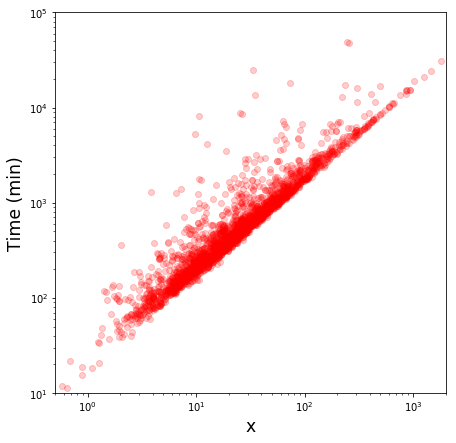

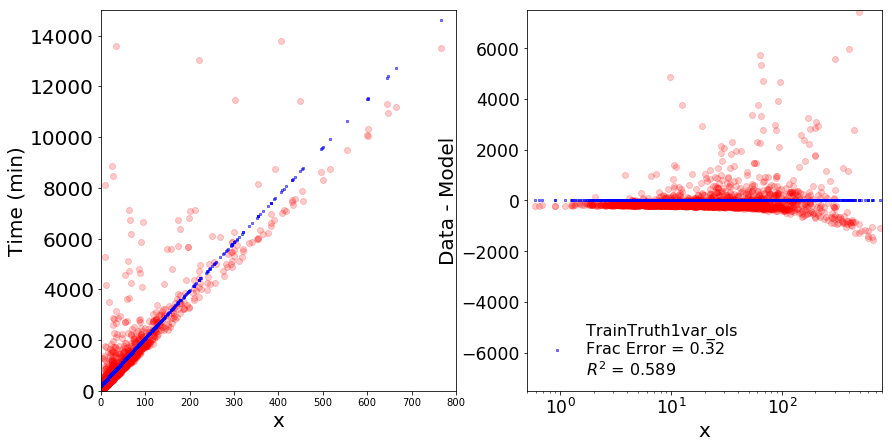

In [17]:
import TDPPredictor
reload(TDPPredictor)
from TDPPredictor import TDPPredictor as tdp

lreg1 = tdp(sd[['Vfil']].as_matrix(),sd['t'].as_matrix(),'ols',"TrainTruth1var")
lreg1.PlotInputs(0.5,2000,'log')
lreg1.Fit()
lreg1.PlotPerformance(0.5,800,'log')

Analysis TrainTruth1var_huber
897.586312334
[ 1747.60043557]
residual standard error (rse): 1587.42203061 residual mean_absolute_error: 265.012295986 <y>:  1092.81239369
ratio (ame):  0.242504841193
R^2 score:  0.579521984929


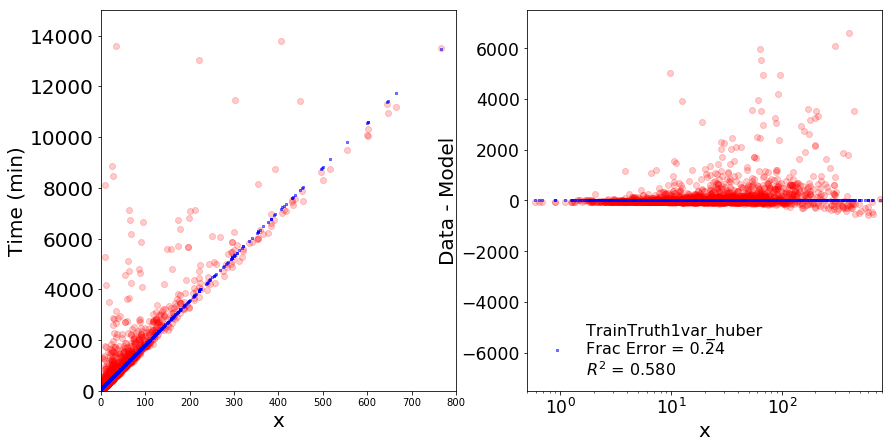

In [18]:
lreg1 = tdp(sd[['Vfil']].as_matrix(),sd['t'].as_matrix(),'huber',"TrainTruth1var")
lreg1.Fit()
lreg1.PlotPerformance(0.5,800,'log')

Analysis TrainTruth2var_huber
1065.23954959
[ 1707.61156152  1589.01820939]
residual standard error (rse): 150.111764818 residual mean_absolute_error: 76.7719171708 <y>:  1092.81239369
ratio (ame):  0.0702516896899
R^2 score:  0.996239999102


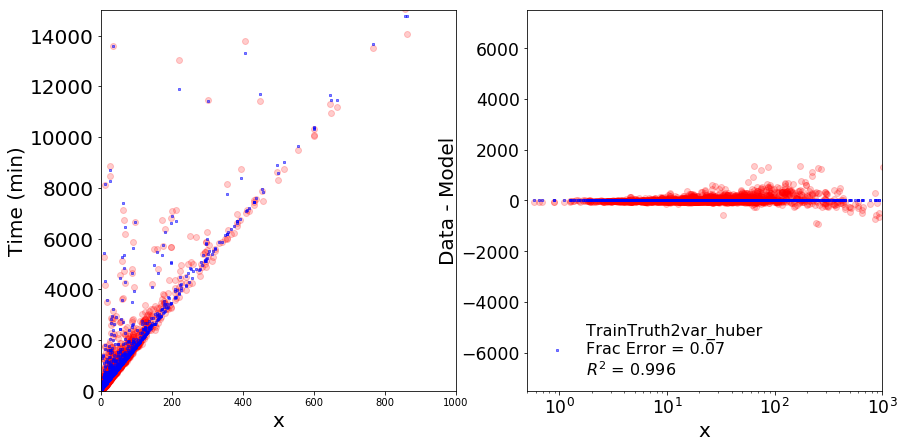

In [19]:
lreg2 = tdp(sd[['Vfil','Vsup']].as_matrix(),sd['t'].as_matrix(),'huber',"TrainTruth2var")
lreg2.Fit()
lreg2.PlotPerformance(0.5,1000,'log')

Analysis TrainDataVmes_huber
943.680191557
[ 1848.75470953]
residual standard error (rse): 1667.03588074 residual mean_absolute_error: 322.392877004 <y>:  1092.81239369
ratio (ame):  0.295012098019
R^2 score:  0.536287949598


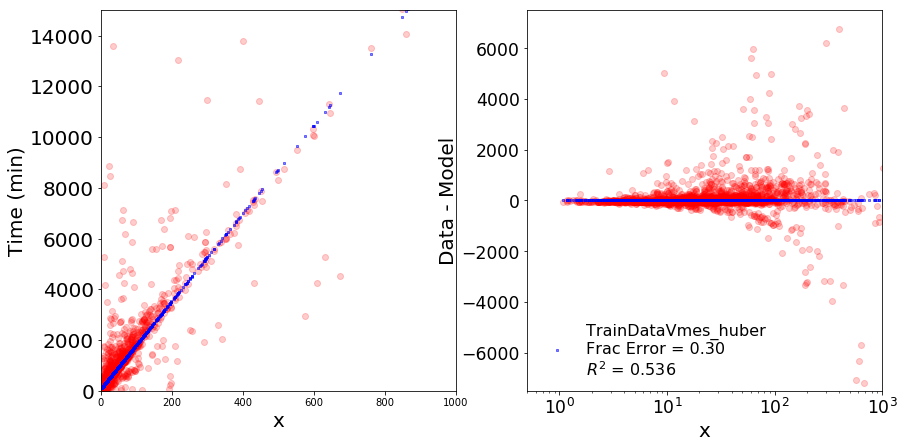

In [20]:
lregdata1 = tdp(sd[['Vmes']].as_matrix(),sd['t'].as_matrix(),'huber',"TrainDataVmes")
#lregdata1.PlotInputs(0.5,2000,'log')
lregdata1.Fit()
lregdata1.PlotPerformance(0.5,1000,'log')

Analysis TrainDataVmesVbb_huber
976.026632821
[ 1686.01382036   245.38391912]
residual standard error (rse): 1621.19718497 residual mean_absolute_error: 300.893184354 <y>:  1092.81239369
ratio (ame):  0.275338371061
R^2 score:  0.561438838068


/anaconda/envs/my_projects_env/lib/python2.7/site-packages/sklearn/linear_model/huber.py:86: RuntimeWarning: invalid value encountered in double_scalars
  squared_loss = weighted_loss / sigma
/anaconda/envs/my_projects_env/lib/python2.7/site-packages/sklearn/linear_model/huber.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  2. / sigma * safe_sparse_dot(weighted_non_outliers, X_non_outliers))
/anaconda/envs/my_projects_env/lib/python2.7/site-packages/sklearn/linear_model/huber.py:96: RuntimeWarning: invalid value encountered in multiply
  2. / sigma * safe_sparse_dot(weighted_non_outliers, X_non_outliers))
/anaconda/envs/my_projects_env/lib/python2.7/site-packages/sklearn/linear_model/huber.py:117: RuntimeWarning: invalid value encountered in double_scalars
  grad[-2] = -2. * np.sum(weighted_non_outliers) / sigma


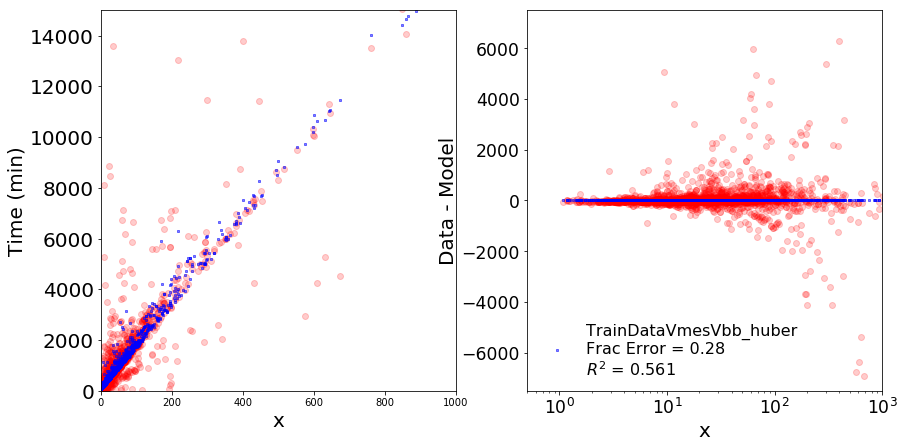

In [21]:
lregdata1 = tdp(sd[['Vmes','Vbb']].as_matrix(),sd['t'].as_matrix(),'huber',"TrainDataVmesVbb")
lregdata1.Fit()
lregdata1.PlotPerformance(0.5,1000,'log')

Analysis TrainDataVmesVch_huber
978.423029816
[ 1670.83386898   274.63270887]
residual standard error (rse): 1604.15360706 residual mean_absolute_error: 291.779660925 <y>:  1092.81239369
ratio (ame):  0.266998857818
R^2 score:  0.570611517434


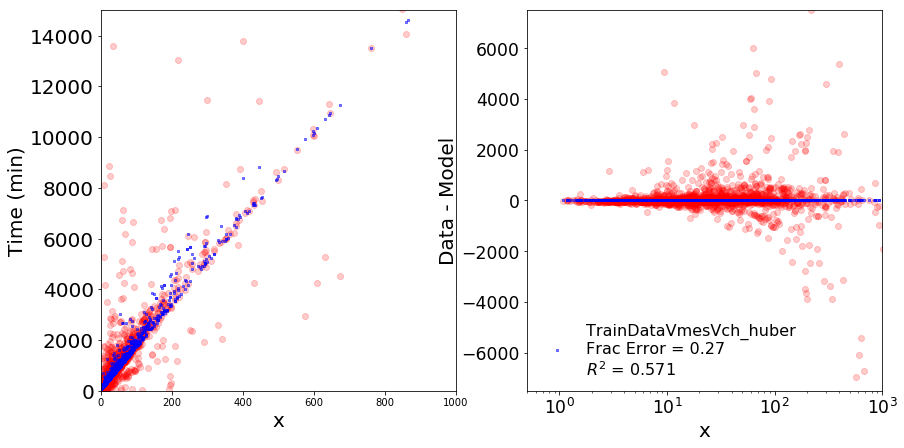

In [22]:
lregdata1 = tdp(sd[['Vmes','Vch']].as_matrix(),sd['t'].as_matrix(),'huber',"TrainDataVmesVch")
#lregdata1.PlotInputs(0.5,2000,'log')
lregdata1.Fit()
lregdata1.PlotPerformance(0.5,1000,'log')

Analysis TrainDataVmesSa_huber
978.383611338
[ 1715.71784668   191.10568085]
residual standard error (rse): 1630.72033434 residual mean_absolute_error: 290.644109437 <y>:  1092.81239369
ratio (ame):  0.265959748549
R^2 score:  0.556271360441


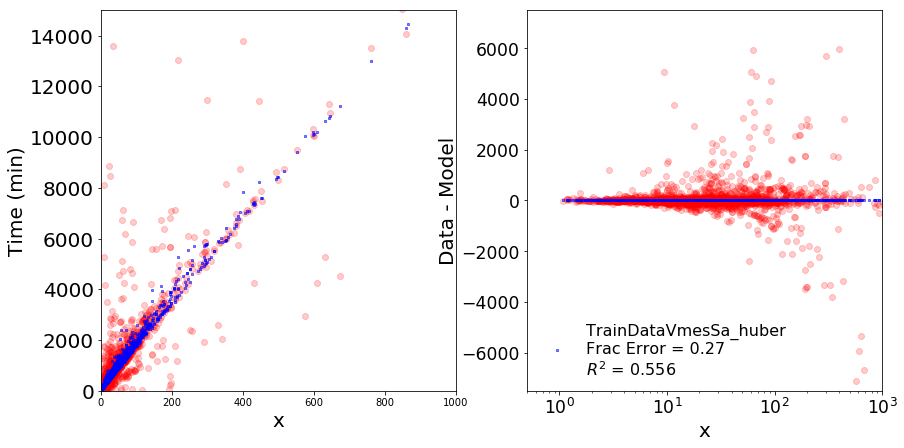

In [23]:
lregdata1 = tdp(sd[['Vmes','Sa']].as_matrix(),sd['t'].as_matrix(),'huber',"TrainDataVmesSa")
lregdata1.Fit()
lregdata1.PlotPerformance(0.5,1000,'log')

Analysis TrainDataVmesZ_huber
957.753075767
[ 1807.62532385    76.23750099]
residual standard error (rse): 1659.53172942 residual mean_absolute_error: 309.173133995 <y>:  1092.81239369
ratio (ame):  0.282915105813
R^2 score:  0.540453346832


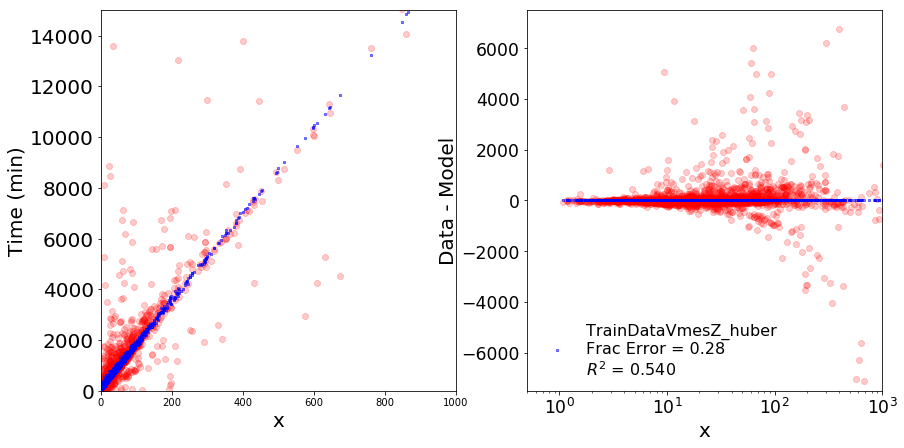

In [24]:
lregdata1 = tdp(sd[['Vmes','Z']].as_matrix(),sd['t'].as_matrix(),'huber',"TrainDataVmesZ")
lregdata1.Fit()
lregdata1.PlotPerformance(0.5,1000,'log')

Analysis TrainDataVmes_rSaVmes_huber
944.994765328
[ 1855.46326015     9.15865638]
residual standard error (rse): 1666.98093824 residual mean_absolute_error: 322.098606092 <y>:  1092.81239369
ratio (ame):  0.294742819492
R^2 score:  0.53631851532


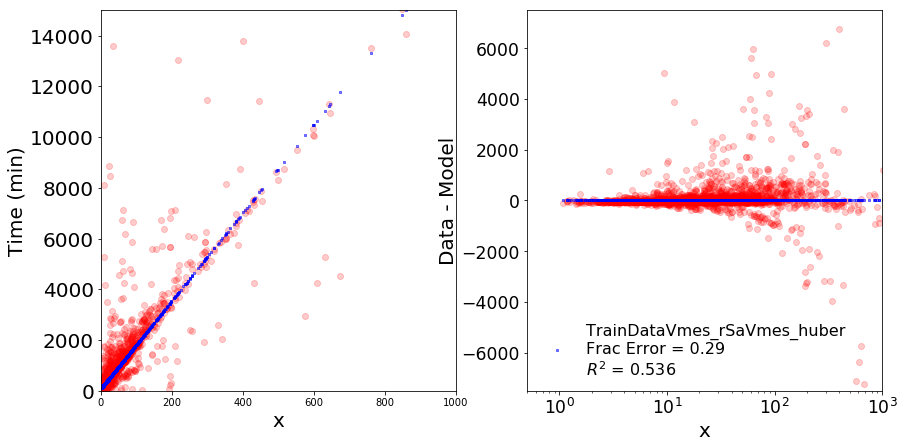

In [25]:
lregdata1 = tdp(sd[['Vmes','rSaVmes']].as_matrix(),sd['t'].as_matrix(),'huber',"TrainDataVmes_rSaVmes")
lregdata1.Fit()
lregdata1.PlotPerformance(0.5,1000,'log')

Analysis TrainDataVmes_Sangover_huber
943.686330617
[  1.84873319e+03   3.08726890e-01]
residual standard error (rse): 1667.03300022 residual mean_absolute_error: 322.39344446 <y>:  1092.81239369
ratio (ame):  0.295012617281
R^2 score:  0.536289552115


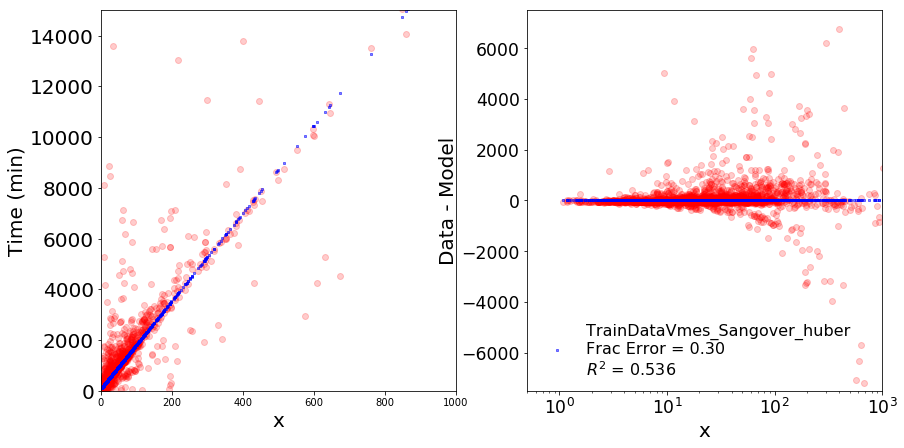

In [26]:
lregdata1 = tdp(sd[['Vmes','Sangover']].as_matrix(),sd['t'].as_matrix(),'huber',"TrainDataVmes_Sangover")
lregdata1.Fit()
lregdata1.PlotPerformance(0.5,1000,'log')

Analysis TrainDataVmes_Vangover_huber
1018.41877891
[ 1792.05338612   605.75594578]
residual standard error (rse): 1616.05814473 residual mean_absolute_error: 296.37808577 <y>:  1092.81239369
ratio (ame):  0.271206739127
R^2 score:  0.564214825271


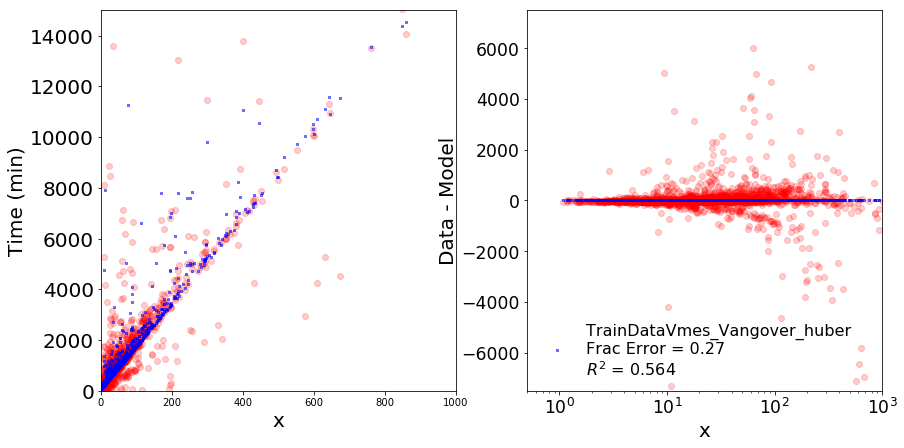

In [27]:
lregdata1 = tdp(sd[['Vmes','Vangover']].as_matrix(),sd['t'].as_matrix(),'huber',"TrainDataVmes_Vangover")
lregdata1.Fit()
lregdata1.PlotPerformance(0.5,1000,'log')

Analysis TrainDataVmes_Vch_Vangover_Z_huber
1025.1437564
[ 1663.44632796   213.20937123   367.61960813    36.28691314]
residual standard error (rse): 1569.4947539 residual mean_absolute_error: 276.308550813 <y>:  1092.81239369
ratio (ame):  0.252841706782
R^2 score:  0.588965549258


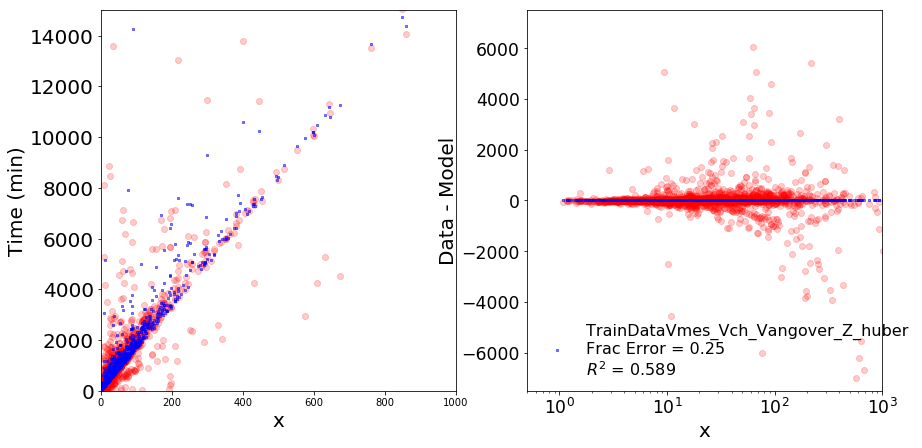

In [28]:
lregdata1 = tdp(sd[['Vmes','Vch','Vangover','Z']].as_matrix(),sd['t'].as_matrix(),'huber',"TrainDataVmes_Vch_Vangover_Z")
lregdata1.Fit()
lregdata1.PlotPerformance(0.5,1000,'log')

In [29]:
sd[['Vfil','Vsup','Vmes','Vbb','Vch','Sa','X','Z','rSaVmes','rVbbVmes','Sangover','Vangover']].corr()

,Vfil,Vsup,Vmes,Vbb,Vch,Sa,X,Z,rSaVmes,rVbbVmes,Sangover,Vangover
Vfil,1.000000,0.115293,0.966274,0.691212,0.692827,0.603401,0.358332,0.428361,-0.270440,-0.083366,0.017902,0.178829
Vsup,0.115293,1.000000,0.103196,0.252897,0.281818,0.207245,0.136805,0.107817,-0.017674,0.067904,0.002613,0.258665
Vmes,0.966274,0.103196,1.000000,0.708182,0.697603,0.606224,0.357222,0.442721,-0.275189,-0.085532,0.015870,0.178519
Vbb,0.691212,0.252897,0.708182,1.000000,0.917626,0.778893,0.487785,0.576837,-0.132441,0.260039,0.033794,0.347899
Vch,0.692827,0.281818,0.697603,0.917626,1.000000,0.864599,0.474166,0.524523,-0.124329,0.166354,0.049697,0.374087
Sa,0.603401,0.207245,0.606224,0.778893,0.864599,1.000000,0.551414,0.476392,-0.038231,0.073741,0.066468,0.346512
X,0.358332,0.136805,0.357222,0.487785,0.474166,0.551414,1.000000,0.036567,-0.039766,0.152858,0.035999,0.160111
Z,0.428361,0.107817,0.442721,0.576837,0.524523,0.476392,0.036567,1.000000,-0.183397,0.163701,0.023911,0.274644
rSaVmes,-0.270440,-0.017674,-0.275189,-0.132441,-0.124329,-0.038231,-0.039766,-0.183397,1.000000,0.443904,0.003117,-0.002557
rVbbVmes,-0.083366,0.067904,-0.085532,0.260039,0.166354,0.073741,0.152858,0.163701,0.443904,1.000000,0.002606,0.098196


Analysis TrainDataVmes_7var_huber
1027.49052574
[ 1677.3429936    129.54340403   -40.26054462    94.08827429    41.68924787
   370.27709323]
residual standard error (rse): 1576.42759867 residual mean_absolute_error: 271.198112415 <y>:  1092.81239369
ratio (ame):  0.248165297155
R^2 score:  0.585326248378


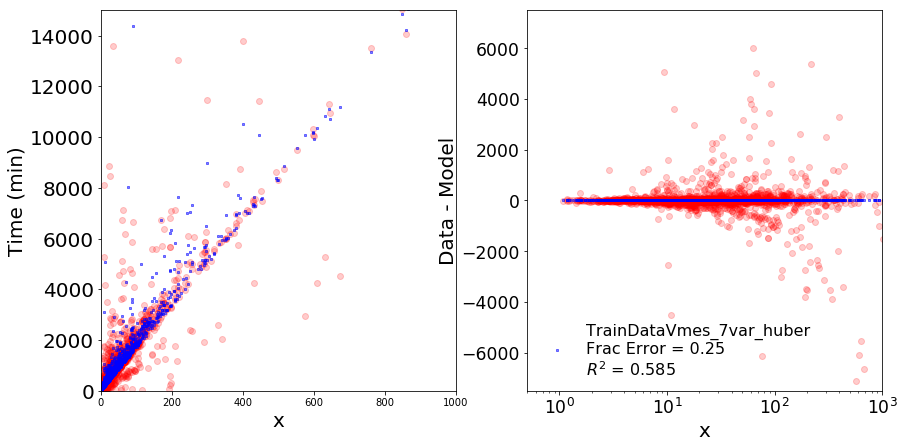

In [30]:
lregdata1 = tdp(sd[['Vmes','Vch','Vbb','Sa','Z','Vangover']].as_matrix(),sd['t'].as_matrix(),'huber',"TrainDataVmes_7var")
lregdata1.Fit()
lregdata1.PlotPerformance(0.5,1000,'log')

Analysis TrainDataVmes_Vsup0_huber
701.859192172
[ 1440.30782107    53.66170907   -29.7621871     57.14245125    24.6859749
    -3.38449719]
residual standard error (rse): 504.323212261 residual mean_absolute_error: 99.1901127767 <y>:  644.458032753
ratio (ame):  0.153912446949
R^2 score:  0.857138229743


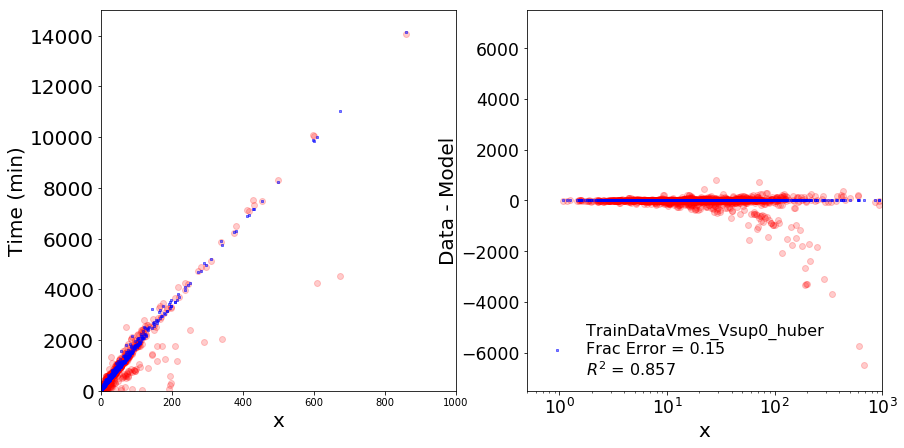

In [44]:
# test ideal case if can classify Vsup
cut=(sd.Vsup<1)
#cut=(sd.Vsup>1)
lregdata1 = tdp(sd[['Vmes','Vch','Vbb','Sa','Z','Vangover']][cut].as_matrix(),sd['t'][cut].as_matrix(),'huber',"TrainDataVmes_Vsup0")
lregdata1.Fit()
lregdata1.PlotPerformance(0.5,1000,'log')

Analysis TrainDataVmes_Vsup0_huber
1667.85196051
[ 2031.15510432   138.37390731   -17.62291543   184.26917971    50.38920477
   481.89615573]
residual standard error (rse): 2589.75071815 residual mean_absolute_error: 562.759242111 <y>:  1969.88515815
ratio (ame):  0.285681243794
R^2 score:  0.486902759418


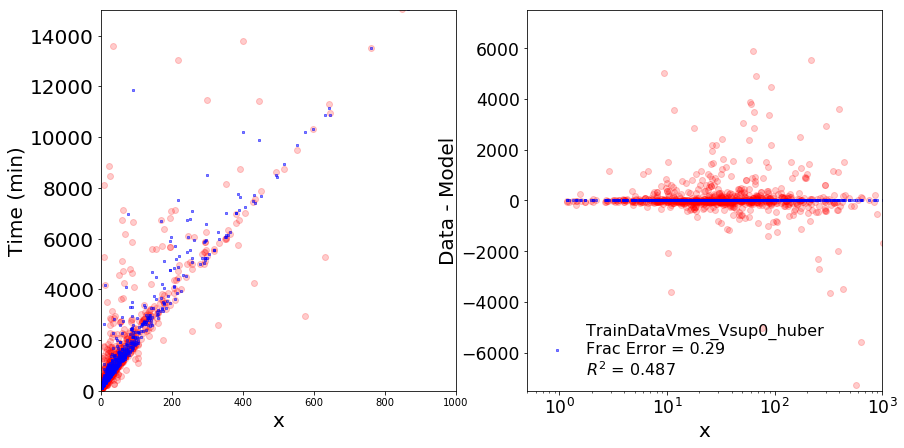

In [45]:
# test ideal case if can classify Vsup
cut=(sd.Vsup>1)
lregdata1 = tdp(sd[['Vmes','Vch','Vbb','Sa','Z','Vangover']][cut].as_matrix(),sd['t'][cut].as_matrix(),'huber',"TrainDataVmes_Vsup1")
lregdata1.Fit()
lregdata1.PlotPerformance(0.5,1000,'log')